In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from IPython.display import clear_output
#%matplotlib inline

# Non-dimensionalized Neuronal Dynamical System
python version of nondim
using H for weight update stdp


In [9]:
def adjacency(D, ai, ao, ri, ro, lam):
    """Calculate intra-layer adjacency matrix encoding the spatial connectivity 
    of neurons within the layer.

    Parameters
    ----------
    D  : distance matrix
    ai : inhibition amplitude factor
    a0 : excittation amplitude factor
    ri : float
        Excitation radius
    ro : float
        Inhibition radius
    """
    
    S = ai * (D < ri) - (ao * (D > ro) *  np.exp(-D/lam))  
    S = S - np.diag(np.diag(S)) 

    return S

In [10]:
nR = 1632
sqR = 28
# Retina 

Ret = {
    "tf" : np.zeros((nR, 1)),
    "th" : np.ones((nR, 1)), # variable retina threshold (theta)
    "b" : np.zeros((nR, 1)),
    "v_reset" : .1 * np.random.randn(nR, 1)**2,
    "nx" : sqR * np.random.rand(nR, 2),
    "ri" : 3, # inner radius
    "ro" : 6, # outer radius
    "u" : np.zeros((nR,1)),  # I.C. of v, u
    "v" :  np.zeros((nR, 1)),
    "H" : np.zeros((nR, 1)), # OG has sparse, see if this will be an issue TODO
    # dynamics parameters
    "lam" : 10,
    "tau_v" : 1,
    "tau_th" : 30,
    "th_plus" : 9,
    "v_th" : 1,
    "htmp" : np.zeros((nR, 1)),# heatmap = of times each neuron spikes
    "ai" : 30,
    "ao" : 10
}

Ret["D"] = squareform(pdist(Ret["nx"])) # distance
Ret["S"] = adjacency(Ret["D"], Ret["ai"],Ret["ao"], Ret["ri"], Ret["ro"], Ret["lam"]) # adjacency matrix 

In [11]:
# Nondimensional Parameters
# Reference variables
Vt = Ret["ao"]; Tt = Ret["tau_v"]; Lt = sqR;

# Non-dimensional groups
piTV_plus = Ret["th_plus"] * Tt / Vt
piT_th = Tt / Ret["tau_th"] 

piV_th = Ret["v_th"] / Vt
piV_reset = Ret["v_reset"] / Vt; 
piV_ai = Ret["ai"] / Vt

piL_ri = Ret["ri"] / Lt
piL_ro = Ret["ro"] / Lt
piL_lam = Ret["lam"] / Lt

# Non-dimensional Spatial Adjacency matrix
Ret["nxs"] = Ret["nx"] / Lt;
Ret["Ds"] = squareform(pdist( Ret["nxs"])); # Non-dimensional distance matrix
Ret["Ss"] = piV_ai * (Ret["Ds"] < piL_ri) - (Ret["Ds"] > piL_ro)* np.exp(-Ret["Ds"] / piL_lam); 
Ret["Ss"] = Ret["Ss"] - np.diag(np.diag(Ret["Ss"]));      # Adjacency matrix between Neurons in Retina

# figure
# subplot(1,2,1), plot([0:0.01:sqR], Ret.ai*([0:0.01:sqR] < Ret.ri)- Ret.ao*([0:0.01:sqR] > Ret.ro).*exp(-[0:0.01:sqR] / Ret.lam)),xlim([0,sqR])
# subplot(1,2,2), plot([0:0.001:1],piV_ai *([0:0.001:1] < piL_ri)- ([0:0.001:1] > piL_ro).*exp(-[0:0.001:1] / piL_lam))

Ret["vs"] = 0*np.ones((nR,1))/Vt; Ret["us"] = 0*np.ones((nR,1))/Vt; Ret["ths"] = np.ones((nR,1))/Vt;
Ret["Hs"] = np.zeros((nR,1)); 
Ret["htmps"] = np.zeros((nR,1));

# Time loop settings & Initialization
Tend = 100; dt = 0.1; tint = np.arange(0,Tend + 1) # (301,) shape
ts = 0;
fnoise = 3*np.random.randn(nR,len(tint)); # Pre-generate noise

Xu = np.zeros((nR,tint[-1])); Xu[:,0] = Ret["u"].reshape(nR,) # Snapshot matrix u
Xv = np.zeros((nR,tint[-1])); Xv[:,0] = Ret["v"].reshape(nR,) # Snapshot matrix v
Xth = np.zeros((nR,tint[-1])); Xth[:,0] = Ret["th"].reshape(nR,)


Xus = np.zeros((nR,tint[-1])); Xus[:,0] = Ret["u"].reshape(nR,) # Snapshot matrix u
Xvs = np.zeros((nR,tint[-1])); Xvs[:,0] = Ret["v"].reshape(nR,) # Snapshot matrix v
Xths = np.zeros((nR,tint[-1])); Xths[:,0] = Ret["th"].reshape(nR,)


# fireR = {}; fireRs = {};
firedMat = {}; firedMats = {}; 

for tt in np.arange(0, Tend - dt, dt):
    if np.round(tt)+1< 100:
        Ret["eta"] = fnoise[:,int(np.round(tt)+1)].reshape(nR,1) # TODO: rounding
        Ret["etas"] = fnoise[:,int(np.round(tt)+1)].reshape(nR,1)/Vt # TODO: rounding
    
    # Solve Wave Dynamical System in Retina

    Ret["u"] = np.matmul(Ret["S"],Ret["H"]) # TODO: fix ret.H --> 1600 x 1 of zeros
    Ret["v"] = Ret["v"] + dt * (1/Ret["tau_v"] * (-Ret["v"] + Ret["u"] + Ret["b"] + Ret["eta"]))
    Ret["th"] = Ret["th"] +  dt * (1/Ret["tau_th"] * (Ret["v_th"] - Ret["th"]) * (1-Ret["H"]) + Ret["th_plus"] * Ret["H"]) 
        

    # Discontinuous Update rule
    fireR = np.argwhere(Ret["v"] >= Ret["th"])[:,0] # get only row indices (#rows, ) shape
    tmpR = Ret["v"]
    Ret["v"][fireR] = Ret["v_reset"][fireR] # replacing voltages of fired neurons with reset voltage
    Ret["H"] = np.zeros((nR, 1)) 
    Ret["H"][fireR,] = np.ones((len(fireR),1)) # 1s where the neurons fire in H #TODOL make sparse
    
    
    # NON-DIMENSIONALIZED Wave DS    
    
    Ret["us"] = np.matmul(Ret["Ss"],Ret["Hs"]) # TODO: fix ret.H --> 1600 x 1 of zeros
    Ret["vs"] = Ret["vs"] + dt * (-Ret["vs"] + Ret["us"] + Ret["etas"])
    Ret["ths"] = Ret["ths"] +  dt * (piT_th * (piV_th - Ret["ths"]) * (1-Ret["Hs"]) + piTV_plus * Ret["Hs"]) 
        

    # NON-DIMENSIONALIZED Update rule
    fireRs = np.argwhere(Ret["vs"] >= Ret["ths"])[:,0] # get only row indices (#rows, ) shape
    tmpRs = Ret["vs"];
    Ret["vs"][fireRs] = piV_reset[fireRs]
    Ret["Hs"] = np.zeros((nR, 1)) 
    Ret["Hs"][fireRs,] = np.ones((len(fireRs),1)) # 1s where the neurons fire in H #TODOL make sparse

    if np.mod(tt, 1) == 0 and tt < Tend-1:
        
        Xv[:,ts+1] = tmpR.reshape(nR,); 
        Xu[:,ts+1] = Ret["u"].reshape(nR,)
        Xth[:,ts+1] = Ret["th"].reshape(nR,);
        Xvs[:,ts+1] = tmpRs.reshape(nR,); Xus[:,ts+1] = Ret["us"].reshape(nR,)
        Xths[:,ts+1] = Ret["ths"].reshape(nR,);
        
        firedMat[ts+1] = fireR; firedMats[ts+1] = fireRs; # making firedMat a dictionary rn
        ts += 1
        Ret["htmp"][fireR,] = Ret["htmp"][fireR,]+1; Ret["htmps"][fireRs,] = Ret["htmps"][fireRs,]+1;



In [12]:
tt

99.80000000000001

In [ ]:
# Plotting

# Visualization of Wave
for ii in range(1, Tend):
    f1 = plt.figure(figsize=(20,5))

    ax1 = f1.add_subplot(121)
    ax1.title.set_text('L_1-Wave t = ' + str(ii))
    ax1.scatter(Ret['nx'][:,0],Ret['nx'][:,1], color = 'k')
    ax1.scatter(Ret['nx'][firedMat[ii],0],Ret['nx'][firedMat[ii],1], color = 'r')
    
    ax2 = f1.add_subplot(122); ax2.title.set_text('L_1 Non-dim. Wave t = ' + str(ii))
    ax2.scatter(Ret['nxs'][:,0], Ret['nxs'][:,1], color = 'k')
    ax2.scatter(Ret['nxs'][firedMats[ii],0], Ret['nxs'][firedMats[ii],1], color = 'r')
    plt.show()
    clear_output(wait=True)

In [ ]:
plt.imshow(Ret["htmp"])

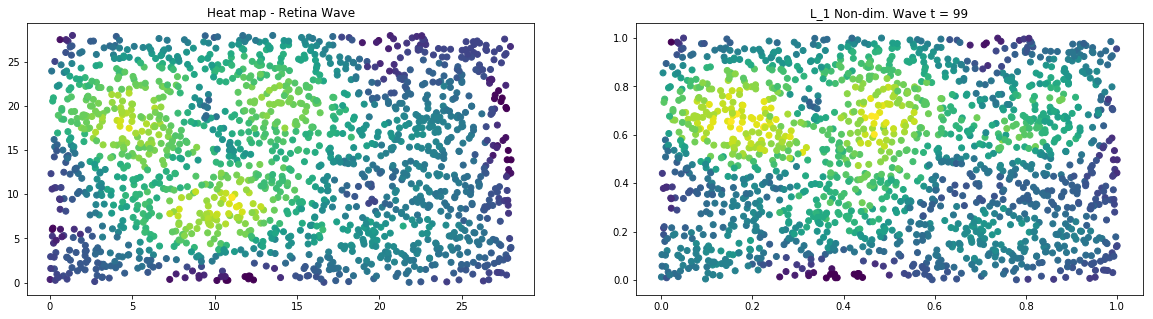

In [70]:

    

# Plotting heat waves
f2 = plt.figure(figsize=(20,5))
ax1 = f2.add_subplot(121)
ax1.title.set_text('Heat map - Retina Wave')
ax1.scatter(Ret['nx'][:,0], Ret['nx'][:,1], c = Ret["htmp"][:,0])
    
ax2 = f2.add_subplot(122); ax2.title.set_text('L_1 Non-dim. Wave t = ' + str(ii))
ax2.scatter(Ret['nxs'][:,0], Ret['nxs'][:,1], c = Ret["htmps"][:,0])



# figure(2),scatter(Ret.nx(:,1),Ret.nx(:,2),[],Ret.htmp(:,end),'filled'), colorbar, title('Heat map - Retina Wave'), axis ij image 
# figure(3),scatter(Ret.nxs(:,1),Ret.nxs(:,2),[],Ret.htmps(:,end),'filled'), colorbar, title('Heat map - Non-dim. Retina Wave'), axis ij image 

# figure(4),subplot(1,3,1),plot(tint(1:end-1),Xv(1:40:end,:),'-o');                          title('Ret.v')
#         subplot(1,3,2),plot(tint(1:end-1),Xu(1:40:end,:),'-o');                            title('Ret.u')
#         subplot(1,3,3),plot(tint(1:end-1),Xth(1:40:end,:),'-o');                           title('Ret.th')
        
# figure(5),subplot(1,3,1),plot(tint(1:end-1),Xvs(1:40:end,:),'-o');                          title('Ret.vs')
#         subplot(1,3,2),plot(tint(1:end-1),Xus(1:40:end,:),'-o');                            title('Ret.us')
#         subplot(1,3,3),plot(tint(1:end-1),Xths(1:40:end,:),'-o');                           title('Ret.ths')


In [71]:
a = sqR * np.random.rand(nR, 2)
b =  np.random.rand(nR, 2)

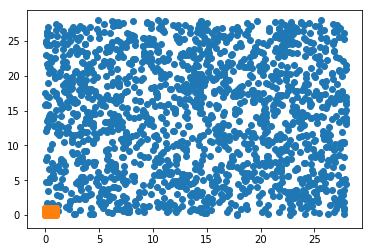

In [72]:
plt.scatter(a[:,0], a[:,1])
plt.scatter(b[:,0], b[:,1])


In [73]:
Ret["htmp"][:].shape

(1632, 1)

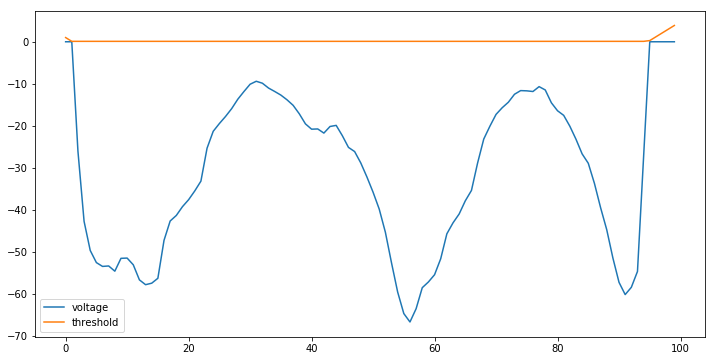

In [14]:
n = 10
plt.figure(figsize=(12,6))
plt.plot(Xvs[n], label = 'voltage')
plt.plot(Xths[n], label = 'threshold')
plt.legend()

In [ ]:
Xths[:50,0:3]

In [40]:
firedMat.keys

<function dict.keys>